In [18]:
%config Completer.use_jedi = False
%matplotlib notebook
import astropy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits
from glob import glob
import os
from tqdm import tqdm_notebook, tnrange, tqdm
#import pandas as pd
from astropy.wcs import WCS
import sys
from spectral_cube import SpectralCube
import fs
import fs.copy
import socket
import warnings

# Table of contents
[Read in data](#data)

[Produce cutouts](#cutouts)

[Get sizes of cutouts](#sizes)

[Write to files](#Write)

[Catalogue setup](#cat)

## Read in data
<a id='data'></a>

In [58]:
sbid = 8585
field = 'RACS_test4_1.05_1049-31A'

# Check host and get file locations
host = socket.gethostname()

if host == 'motley':
    rootdir= '/priv/myrtle2/possum/thomson/cubes'
    warnings.warn("Data is on remote disk. Read/Write will be slow.")
    
if host[:6] == 'galaxy' or host[:4] == 'zeus':
    rootdir = '/group/askap/mcc381/RACS'
    warnings.warn("Data is on remote disk. Read/Write will be slow.")

if host == 'avatar':
    rootdir = '/avatar/athomson/cubes'

/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Data is on remote disk. Read/Write will be slow.
  if __name__ == '__main__':


In [41]:
# Glob out the necessary files
cubes = glob(f'{rootdir}/{sbid}/{field}/image.restored.*contcube*linmos*fits') # Data cubes
selavyfits = glob(f'{rootdir}/{sbid}/{field}/selavy*/*.fits') # Selavy images
votab = glob(f'{rootdir}/{sbid}/{field}/selavy*/*island*.xml') # Selvay VOTab
# Get selvay data from VOTab
islands = Table.read(votab[0], format='votable') 

In [61]:
print(islands)

               col_island_id                col_island_name ... col_comment
                     --                                     ...            
------------------------------------------- --------------- ... -----------
   SB8583_RACS_test4_1.05_1049-31A_island_1  J103313-341845 ...            
  SB8583_RACS_test4_1.05_1049-31A_island_10  J110106-314027 ...            
 SB8583_RACS_test4_1.05_1049-31A_island_100  J110629-315014 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1000  J103747-273007 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1001  J105404-302031 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1002  J110142-333425 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1003  J103831-304818 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1004  J110506-331306 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1005  J103307-341847 ...            
SB8583_RACS_test4_1.05_1049-31A_island_1006  J104642-285804 ...            
            

In [48]:
print('Getting source-fiding results from:', votab,'\n')
print('Getting spectral data from:', cubes, '\n')
print('Getting source location data from:', selavyfits, '\n')

Getting source-fiding results from: ['/priv/myrtle2/possum/thomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy/selavy-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.islands.xml'] 

Getting spectral data from: ['/priv/myrtle2/possum/thomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.i.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits'] 

Getting source location data from: ['/priv/myrtle2/possum/thomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy/componentMap_image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.fits'] 



In [49]:
# Read data using Spectral cube
i_taylor = SpectralCube.read(selavyfits[0], mode='denywrite')
wcs_taylor = WCS(i_taylor.header)
i_cube = SpectralCube.read(cubes[0], mode='denywrite')
wcs_cube = WCS(i_cube.header)
q_cube = SpectralCube.read(cubes[1], mode='denywrite')
u_cube = SpectralCube.read(cubes[2], mode='denywrite')

IndexError: list index out of range

Source finding was done on full field, but cubes are only 16 beam. So we need to convert from image pixel locations to WCS to cube pixel locations

In [50]:
# Get bounding boxes in WCS
ra_min, dec_min, freq = wcs_taylor.all_pix2world(islands['col_x_min'], islands['col_y_min'], 0, 0)
ra_max, dec_max, freq = wcs_taylor.all_pix2world(islands['col_x_max'], islands['col_y_max'], 0, 0)

# Get bounding boxes in cube pixels
x_min, y_min, _ = np.array(wcs_cube.all_world2pix(ra_min, dec_min, freq, 0)).astype(int)
x_max, y_max, _ = np.array(wcs_cube.all_world2pix(ra_max, dec_max, freq, 0)).astype(int)
dy, dx = y_max - y_min, x_max-x_min

## Produce cutouts
<a id='cutouts'></a>

In [51]:
# Init cutouts
i_cutouts = []
q_cutouts = []
u_cutouts = []
outdir = f'{rootdir}/{sbid}/{field}/cutouts/'
source_dict_list = []

try:
    os.mkdir(outdir)
except:
    print('Directory exists')

In [52]:
pad = 3 # Chose pad fraction of bounding box around source
for i in tnrange(len(islands)):
    source_dict = {}
    # Skip if source is outside of cube bounds
    if y_max[i]>i_cube.shape[2] or x_max[i]>i_cube.shape[2] or x_min[i]<0 or y_min[i]<0:
        continue
    # Check if pad puts bbox outside of cube
    elif int(y_min[i]-pad*dy[i]) > 0 and int(x_min[i]-pad*dx[i]) > 0 and \
        int(y_max[i]+pad*dy[i]) < i_cube.shape[2] and int(x_max[i]+pad*dx[i]) < i_cube.shape[2]:
        i_cutout = i_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        q_cutout = q_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        u_cutout = u_cube[:,int(y_min[i]-pad*dy[i]):int(y_max[i]+pad*dy[i]), \
                             int(x_min[i]-pad*dx[i]):int(x_max[i]+pad*dx[i])]
        i_cutouts.append(i_cutout)
        q_cutouts.append(q_cutout)
        u_cutouts.append(u_cutout)
        
        source_dict['header'] = i_cutout.header
        for name in islands.colnames:
            source_dict[name.replace('col_', '')] = islands[name][i]
        source_dict_list.append(source_dict)
    else:
        i_cutout = i_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        q_cutout = q_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        u_cutout = u_cube[:,y_min[i]:y_max[i], x_min[i]:x_max[i]]
        i_cutouts.append(i_cutout)
        q_cutouts.append(q_cutout)
        u_cutouts.append(u_cutout)
        
        source_dict['header'] = i_cutout.header
        for name in islands.colnames:
            source_dict[name.replace('col_', '')] = islands[name][i]
        source_dict_list.append(source_dict)

NameError: name 'q_cube' is not defined

In [12]:
# Set up locations where files will be saved
for i in tnrange(len(source_dict_list)):
    for stoke in ['i','q','u']:
        name = source_dict_list[i]['island_name']
        outname = f'{outdir}image.restored.{stoke}.SB.{sbid}.contcube.{field}.cutout.{name}.fits'
        source_dict_list[i][f'{stoke}_file'] = outname

## Get sizes of cutouts
<a id='sizes'></a>

In [73]:
sizes_bytes = []
for i in tnrange(len(i_cutouts)):
    sizes_bytes.append(i_cutouts[i][0,:,:].nbytes*i_cutouts[i].shape[0]*1e-6)
    
sizes_bytes = np.array(sizes_bytes)


In [74]:
print('Size in MB: ',sizes_bytes.sum())
print('Size in GB: ',sizes_bytes.sum()/1000)

Size in MB:  14604.477695999998
Size in GB:  14.604477695999998


## Write to files
<a id='Write'></a>

***

### Mem_FS tests
_No longer needed_

_Used for testing bottlenecks_

Testing with a memory filesystem. This _should_ be the fastest possible write.

In [ ]:
with mem_fs as MemoryFS():
    mem_fs.makedirs('cutouts')
    for i in tnrange(len(i_cutouts)):
        outname_mem = f'cutouts/image.restored.{stoke}.SB.{sbid}.contcube.{field}.cutout.{name}.fits'
        with mem_fs.open(outname_mem, 'wb') as fitsfile:
            i_cutouts[i].write(fitsfile, overwrite=True, format='fits')
    for path in mem_fs.walk.files(path='cutouts'):
        print(path)

***

### Write to disk

In [5]:
def writefits(arg):
    """Write cutouts to disk.

    Writes a cutout, as stored in source_dict, to disk. The file location
    should already be specified in source_dict. This format is intended 
    for parallel use with pool.map syntax.

    Args:
        arg: The tuple of (i, stoke)
            i: The index of the source in source_dict to write to disk.
            stoke: Which Stokes to write. Is a string of either 'i', 
                'q', or 'u'.
    """
    i, stoke = arg
    outfile = source_dict[f'{stoke}_file'][i]
    if stoke=='i':
        i_cutouts[i].write(outfile, format='fits', overwrite=True)
    if stoke=='q':
        q_cutouts[i].write(outfile, format='fits', overwrite=True)
    if stoke=='u':
        u_cutouts[i].write(outfile, format='fits', overwrite=True)

In [7]:
import schwimmbad
from multiprocessing import cpu_count

In [8]:
n_cores = cpu_count() # Use all available cores
use_mpi = False # Use or not with Schwimmbad

In [34]:
# Use Schwimmbad to write all cutouts to disk in parallel
with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
    for stoke in ['i','q','u']:
        if use_mpi:
            pool.map(writefits, [[i, stoke] for i in range(len(i_cutouts))])
        else:
            r=list(tqdm_notebook(pool.imap_unordered(writefits, 
                                              [[i, stoke] for i in range(len(i_cutouts))]),
                         total = len(i_cutouts)
                         ))

## Catalogue setup
<a id='cat'></a>

Currently the data is passed from a dictionary, to a dataclass, and then to JSON format. This works with a MongoDB approach.

To-do: Format the data for SQL formatting. Or, possibly just a VOTable. Whatever ends up being the best.

In [55]:
from dataclasses import dataclass, asdict, make_dataclass
import dataclasses
from astropy.coordinates import SkyCoord
from astropy.io.fits import Header
import astropy.units as u
import json


In [54]:
print(source_dict_list[0].keys())

IndexError: list index out of range

In [59]:
# Create a dataclass with source_dict keys at attributes
cube_class = make_dataclass('cube_class',
                            [(key, type(source_dict_list[0][key])) for key in source_dict_list[0].keys()]
                             )

IndexError: list index out of range

In [56]:
def head2dict(h):
    """Convert FITS header to a dict.

    Writes a cutout, as stored in source_dict, to disk. The file location
    should already be specified in source_dict. This format is intended 
    for parallel use with pool.map syntax.

    Args:
        h: An astropy FITS header.
     
    Returns:
        data: The FITS head converted to a dict.
    """
    data = {}
    for i, c in enumerate(h.__dict__['_cards']):
        if c[0] == '': continue
        data[c[0]] = c[1]
    return(data)

In [57]:
class MyEncoder(json.JSONEncoder):
    """Cutom JSON encorder.
    
    Parses the data stored in source_dict to JSON without
    errors.
    """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, fits.Header):
            return head2dict(obj)
        elif dataclasses.is_dataclass(obj):
                return dataclasses.asdict(obj)
        else:
            return super(MyEncoder, self).default(obj)

In [150]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)

In [315]:
mydb = client['racs']  # database

In [316]:
mycol = mydb['cubelets']  # collection; can also call as db['dwarfs']
#cublet_db.drop()

In [314]:
mycol.drop()

In [198]:
json_data = json.loads(json.dumps(source_dict_list[0], cls=MyEncoder))

In [199]:
result = mycol.insert_one(json_data)

In [200]:
result.inserted_id

ObjectId('5d89a6b9f91aee84857544af')

In [201]:
print(mydb.list_collection_names())


['cubelets']


In [202]:
# Quick check to confirm load
x = mycol.find_one()

x['q_file']

'/avatar/athomson/cubes/8585/<function field at 0x2b292a77b620>/cutouts/image.restored.q.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J110106-314027.fits'

In [231]:
source_dict['q_file']

'/avatar/athomson/cubes/8585/<function field at 0x2b292a77b620>/cutouts/image.restored.q.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J110106-314027.fits'

In [317]:
for source_dict in tqdm_notebook(source_dict_list):
    json_data = json.loads(json.dumps(source_dict, cls=MyEncoder))
    name = source_dict['island_name']
    count = mycol.count_documents({'island_name': name})

    if count > 0:
        # Replace existing
        cursor = mycol.find({'island_name': name})
        for doc in cursor:
            result = mycol.replace_one({'_id': doc['_id']}, json_data)
    else:
        # Insert new
        result = mycol.insert_one(json_data)

In [318]:
count = mycol.count_documents({})
print('Total documents: ', count)

Total documents:  3399


In [319]:
myquery = { "flux_int": { "$gt": 20 } }

mydoc = mycol.find(myquery, { "_id": 0, "island_name": 1, "flux_int": 1 , "ra_deg_cont": 1, "dec_deg_cont": 1})

for x in mydoc:
    print(x)

{'island_name': 'J110106-314027', 'ra_deg_cont': 165.278278, 'dec_deg_cont': -31.674425, 'flux_int': 48.24599838256836}
{'island_name': 'J104609-292044', 'ra_deg_cont': 161.540327, 'dec_deg_cont': -29.345593, 'flux_int': 28.7810001373291}
{'island_name': 'J105513-341853', 'ra_deg_cont': 163.808001, 'dec_deg_cont': -34.314945, 'flux_int': 70.49400329589844}
{'island_name': 'J105533-283134', 'ra_deg_cont': 163.889301, 'dec_deg_cont': -28.526133, 'flux_int': 122.49299621582031}
{'island_name': 'J104255-284917', 'ra_deg_cont': 160.73015, 'dec_deg_cont': -28.821574, 'flux_int': 26.259000778198242}
{'island_name': 'J103716-293402', 'ra_deg_cont': 159.316835, 'dec_deg_cont': -29.567353, 'flux_int': 60.4630012512207}
{'island_name': 'J110209-303841', 'ra_deg_cont': 165.539006, 'dec_deg_cont': -30.644752, 'flux_int': 31.884000778198242}
{'island_name': 'J110218-310245', 'ra_deg_cont': 165.578578, 'dec_deg_cont': -31.045928, 'flux_int': 30.996999740600586}
{'island_name': 'J110331-325115', 'ra_d

In [321]:
# Remove any existing coords.loc field
mycol.update_many({}, {'$unset': {'coords.loc': ''}}) 

# Loop over those without coords.healpix and set the value
cursor = mycol.find({'coords.loc': {'$exists': False}})
for doc in tqdm_notebook(cursor):
    # RA must have values between -180 and 180
    geojson = { 'type': "Point", 'coordinates': [ doc['ra_deg_cont']-180., doc['dec_deg_cont'] ] }
    #print(doc['island_name'], doc['ra_deg_cont'], doc['ra_deg_cont'], geojson)
    mycol.update_one({'_id': doc['_id']}, {'$set': {'coords.loc': geojson}})

In [322]:
if 'geosphere' not in mycol.index_information():
    mycol.create_index([('coords.loc', pymongo.GEOSPHERE)],
                          name='geosphere', background=True)

In [323]:
def wgs_scale(lat):
    # Get scaling to convert degrees to meters at a given geodetic latitude (declination)
    
    # Values from WGS 84
    a = 6378137.000000000000 # Semi-major axis of Earth
    b = 6356752.314140000000 # Semi-minor axis of Earth
    e = 0.081819190842600 # eccentricity
    angle = np.radians(1.0)
    
    # Compute radius of curvature along meridian (see https://en.wikipedia.org/wiki/Meridian_arc)
    rm = a * (1 - np.power(e, 2)) / np.power( ( (1 - np.power(e, 2) * np.power( np.sin(np.radians(lat)), 2) ) ), 1.5)
    
    # Compute length of arc at this latitude (meters/degree)
    arc = rm * angle
    return arc

In [287]:
ra, dec = 165., -30.
lon, lat = ra-180., dec
radius = 1 # degrees
radius *= wgs_scale(lat) # meters
print(lon, lat, radius)

# Perform the search
cursor = mycol.find({'coords.loc': {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': radius
    } } })
for doc in cursor:
    print(doc['island_name'], doc['ra_deg_cont'], doc['dec_deg_cont'], doc['coords']['loc'])

-15.0 -30.0 110852.44249561735
J110018-300016 165.076099 -30.004677 {'type': 'Point', 'coordinates': [-14.923901, -30.004677]}
J110000-295341 165.001608 -29.894778 {'type': 'Point', 'coordinates': [-14.998391999999996, -29.894778]}
J110025-295636 165.104363 -29.943561 {'type': 'Point', 'coordinates': [-14.895636999999994, -29.943561]}
J110016-295303 165.067189 -29.88433 {'type': 'Point', 'coordinates': [-14.932810999999987, -29.88433]}
J105932-300624 164.884517 -30.106834 {'type': 'Point', 'coordinates': [-15.115483000000012, -30.106834]}
J110031-300527 165.132414 -30.091035 {'type': 'Point', 'coordinates': [-14.867585999999989, -30.091035]}
J105954-300900 164.97627 -30.149834 {'type': 'Point', 'coordinates': [-15.02373, -30.149834]}
J105927-300709 164.865099 -30.119259 {'type': 'Point', 'coordinates': [-15.134901000000013, -30.119259]}
J105926-295152 164.859416 -29.864488 {'type': 'Point', 'coordinates': [-15.14058399999999, -29.864488]}
J110036-300850 165.150782 -30.147252 {'type': '

In [324]:
def cone_search(ra, dec, radius, collection=mycol, field='coords.loc'):
    
    scaling = wgs_scale(dec)
    meter_radius = radius * scaling
    lon, lat = ra-180., dec
    
    cursor = collection.find({'coords.loc': {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': meter_radius
    } } })
    
    return cursor

In [353]:
import pprint

In [359]:
cursor = cone_search(165., -30., 0.1)
for doc in cursor:
    pprint.pprint(doc,indent=2)

{ '_id': ObjectId('5d89b309f91aee8485757db9'),
  'background_noise': 0.3149999976158142,
  'beam_area': 0.03999999910593033,
  'comment': '',
  'coords': {'loc': {'coordinates': [-14.923901, -30.004677], 'type': 'Point'}},
  'dec_deg_cont': -30.004677,
  'dec_dms_cont': '-30:00:16',
  'flag_i1': 0,
  'flag_i2': 0,
  'flag_i3': 0,
  'flag_i4': 0,
  'flux_int': 0.16899999976158142,
  'flux_int_err': 0.0,
  'flux_peak': 3.319000005722046,
  'freq': 887.5,
  'header': { 'ALTRPIX': 1.0,
              'ALTRVAL': 272562691.5565,
              'BEAM': 'Beam: BMAJ=17.955658518001847 arcsec '
                      'BMIN=11.140361221160449 arcsec BPA=-51.9109619213644 '
                      'deg',
              'BITPIX': -32,
              'BMAJ': 0.00498768292166718,
              'BMIN': 0.00309454478365568,
              'BPA': -51.9109619213644,
              'BSCALE': 1.0,
              'BTYPE': 'Intensity',
              'BUNIT': 'beam-1 Jy',
              'BZERO': 0.0,
              'CDEL

In [338]:
%matplotlib inline

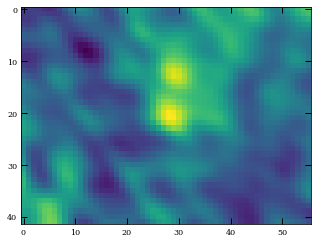

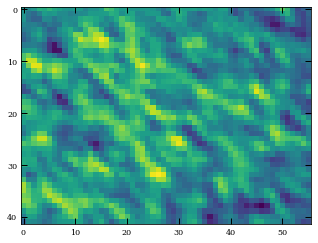

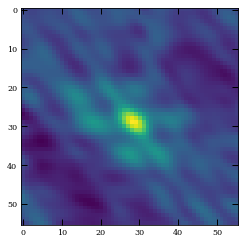

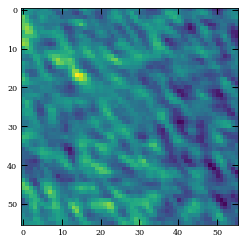

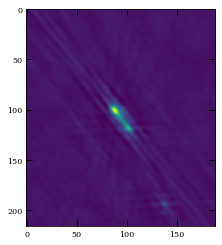

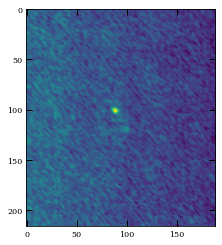

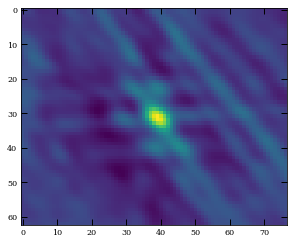

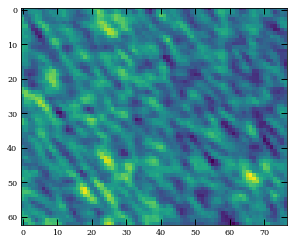

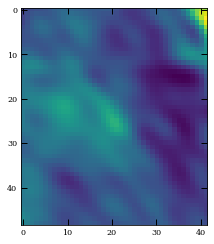

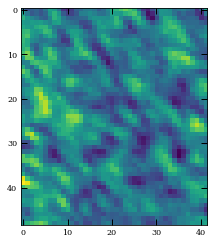

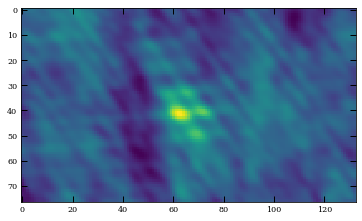

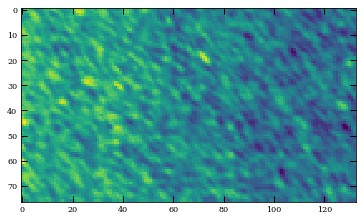

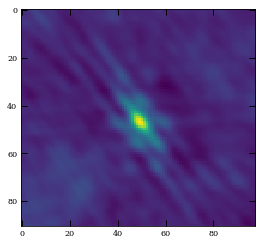

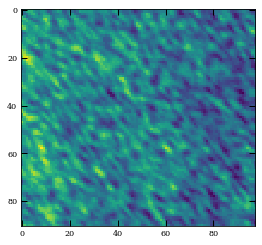

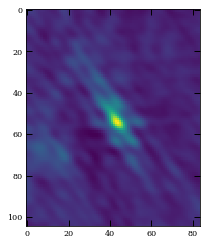

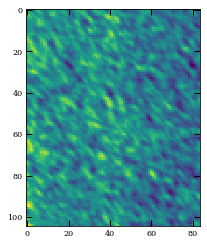

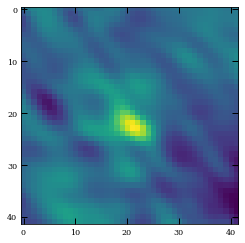

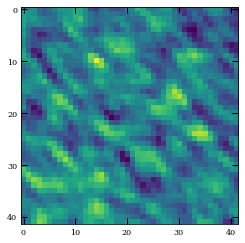

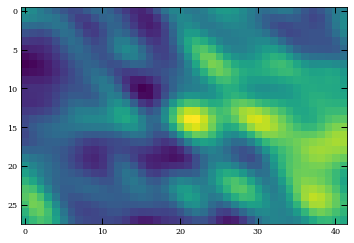

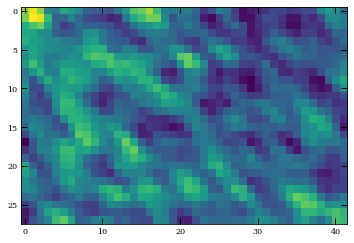

In [350]:
# Use the function
cursor = cone_search(165., -30., 0.2)
for doc in cursor:
    temp_file = doc['i_file']
    cube_temp = SpectralCube.read(temp_file)
    plt.figure()
    cube_temp.moment0(axis=0).quicklook(use_aplpy=False)
    
    temp_q_file = doc['q_file']
    cube_q_temp = SpectralCube.read(temp_q_file)
    temp_u_file = doc['u_file']
    cube_u_temp = SpectralCube.read(temp_u_file)
    cube_p_temp = (cube_q_temp**2 + cube_u_temp**2)**0.5
    plt.figure()
    cube_p_temp.moment0(axis=0).quicklook(use_aplpy=False)
    #fig.figsize(2,2)

# MySQL

In [2]:
import mysql.connector as mysql

In [8]:
import mysql.connector
from mysql.connector import errorcode

try:
    cnx = mysql.connector.connect(user='athomson')
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cnx.close()

2003 (HY000): Can't connect to MySQL server on '127.0.0.1' (111)


In [9]:
cnx = mysql.connector.connect(user='scott', password='password',
                              host='127.0.0.1',
                              database='employees')

DatabaseError: 2003 (HY000): Can't connect to MySQL server on '127.0.0.1' (111)

In [ ]:
cat /etc/os-release